## Continuation of previous notebook on PANDAS

This is the continuation of previous notebook on PANDAS

We use now two dataframes
pubs_df containing publications
affs_df containing affiliations (for all items in pubs_df, thus also Bocconi co-authors)

both loaded from csv files and with a common index UID



In [1]:
import pandas as pd

pubs_df = pd.read_csv("wos_publications.csv")
affs_df = pd.read_csv("wos_affiliations.csv")


First stepp let's have a peek to the new dataset

In [2]:
affs_df.head()

,UID,addr_num,organization,suborganization,full_address,city,state,country,zip
0,WOS:000071806400001,1,UNIVERSITA DI MODENA E REGGIO EMILIA,NaN,"UNIV MODENA, MILAN, ITALY",MILAN,NaN,ITALY,NaN
1,WOS:000071806400001,2,UNIV L BOCCONI,NaN,"UNIV L BOCCONI, MILAN, ITALY",MILAN,NaN,ITALY,NaN
2,WOS:000072608300005,1,UNIVERSITY OF OXFORD,NaN,"UNIV OXFORD NUFFIELD COLL, OXFORD OX1 1NF, ENG...",OXFORD,NaN,ENGLAND,OX1 1NF
3,WOS:000072608300005,2,UNIV BOCCONI,NaN,"UNIV BOCCONI, MILAN, ITALY",MILAN,NaN,ITALY,NaN
4,WOS:000073333300005,1,UNIVERSITY OF URBINO,FAC ECON,"UNIV URBINO, FAC ECON, ISA, I-61029 URBINO, ITALY",URBINO,NaN,ITALY,I-61029


In [4]:
affs_df.isna().sum()  #see how many nulls

UID                   0
addr_num              0
organization          0
suborganization    3829
full_address          0
city                  0
state              9138
country               0
zip                5610
dtype: int64

In [5]:
affs_df.describe() # data composition

,addr_num
count,11043.000000
mean,3.424160
std,6.162924
min,1.000000
25%,1.000000
50%,2.000000
75%,4.000000
max,99.000000


### Searching / selecting data data: 

Using a single colum to select data:
df[df.A > val]

to select a list of possible values use isin

df[df.A.isin(['val1', 'val2'...])

We use isin() also when the value to search is a DF or list with one only value.

In examples below we show records where the number of addresses (addr_num) is te max (99)
and where country of affiliations is ENGLAND or USA


In [2]:

a99 =affs_df[affs_df.addr_num >=99]

affs_df[ affs_df.UID.isin( a99['UID'])].sort_values(by=['organization']).head()

,UID,addr_num,organization,suborganization,full_address,city,state,country,zip
184,WOS:000082926900005,73,ACXEL INT,NaN,"ACXEL INT, NEW YORK, NY USA",NEW YORK,NY,USA,NaN
187,WOS:000082926900005,76,ALEXANDRIA UNIVERSITY,NaN,"ALEXANDRIA UNIV, ALEXANDRIA, EGYPT",ALEXANDRIA,NaN,EGYPT,NaN
167,WOS:000082926900005,58,ALTSCHUL CONSULTORES,NaN,"ALTSCHUL CONSULTORES, BUENOS AIRES, DF, ARGENTINA",BUENOS AIRES,DF,ARGENTINA,NaN
169,WOS:000082926900005,6,ARAB FUND ECON & SOCIAL DEV,NaN,"ARAB FUND ECON & SOCIAL DEV, KUWAIT, KUWAIT",KUWAIT,NaN,KUWAIT,NaN
134,WOS:000082926900005,28,ATHENS UNIVERSITY OF ECONOMICS & BUSINESS,NaN,"ATHENS UNIV ECON & BUSINESS, ATHENS, GREECE",ATHENS,NaN,GREECE,NaN


In [46]:
pubs_df[pubs_df.UID.isin( a99['UID'])]

,UID,accession_no,issn,eissn,doi,doc_type,source,itemtitle,pubyear,pubmonth,...,pubtype,issue,supplement,special_issue,part_no,indicator,is_archive,has_abstract,oases_type_gold,abstract
47,WOS:000082926900005,242FC,1048-9843,1873-3409,NaN,Article,LEADERSHIP QUARTERLY,Culture specific and cross-culturally generali...,1999,SUM,...,Journal,2,NaN,NaN,NaN,NaN,NaN,Y,NaN,\r\n<p>This study focuses on culturally endors...


In [65]:
affs_df[affs_df.country.isin(['ENGLAND','USA' ])].head(10)

,UID,addr_num,organization,suborganization,full_address,city,state,country,zip
2,WOS:000072608300005,1,UNIVERSITY OF OXFORD,NaN,"UNIV OXFORD NUFFIELD COLL, OXFORD OX1 1NF, ENG...",OXFORD,NaN,ENGLAND,OX1 1NF
7,WOS:000073475100004,1,UNIVERSITY OF TEXAS AUSTIN,DEPT ECON,"UNIV TEXAS, DEPT ECON, AUSTIN, TX 78712 USA",AUSTIN,TX,USA,78712
12,WOS:000073954500017,1,UNIVERSITY OF NORTH TEXAS SYSTEM,COLL BUSINESS ADM,"UNIV N TEXAS, COLL BUSINESS ADM, DENTON, TX 76...",DENTON,TX,USA,76203
13,WOS:000073954500017,2,UNIVERSITY OF CALIFORNIA SYSTEM,HAAS SCH BUSINESS,"UNIV CALIF BERKELEY, HAAS SCH BUSINESS, BERKEL...",BERKELEY,CA,USA,94720
23,WOS:000074426600005,3,CEPR,NaN,"CEPR, LONDON, ENGLAND",LONDON,NaN,ENGLAND,NaN
28,WOS:000075193000005,1,UNIVERSITY OF CALIFORNIA SYSTEM,DEPT ECON,"UNIV CALIF BERKELEY, DEPT ECON, BERKELEY, CA 9...",BERKELEY,CA,USA,94720
32,WOS:000075239200006,1,WORLD BANK,NaN,"WORLD BANK, WASHINGTON, DC 20433 USA",WASHINGTON,DC,USA,20433
50,WOS:000077559000004,2,CEPR,NaN,"CEPR, LONDON, ENGLAND",LONDON,NaN,ENGLAND,NaN
66,WOS:000079236600001,3,UNIVERSITY OF MICHIGAN SYSTEM,SCH BUSINESS,"UNIV MICHIGAN, WILLIAM DAVIDSON INST, SCH BUSI...",ANN ARBOR,MI,USA,48109
67,WOS:000079236600001,3,UNIVERSITY OF MICHIGAN SYSTEM,WILLIAM DAVIDSON INST,"UNIV MICHIGAN, WILLIAM DAVIDSON INST, SCH BUSI...",ANN ARBOR,MI,USA,48109


### Drawing an histogram

Next step is to use hist() Pandas function to draw an histogram by country

First one counts the number of countries by number of occurrences; it autosizes the steps

Populating the interactive namespace from numpy and matplotlib


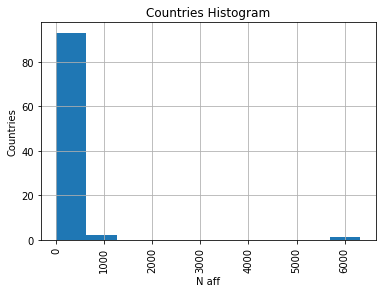

In [76]:
import matplotlib.pyplot as plt
%pylab inline

grouped=affs_df.groupby('country')
# print(grouped['UID'].count())
grouped['UID'].count().hist(xrot=90, bins=10)

plt.ylabel('Countries')
plt.xlabel('N aff')
plt.title('Countries Histogram')
plt.show()




One country has a value around 6K
let's plot a reduced dataset (count >=100) 
to see which one is it

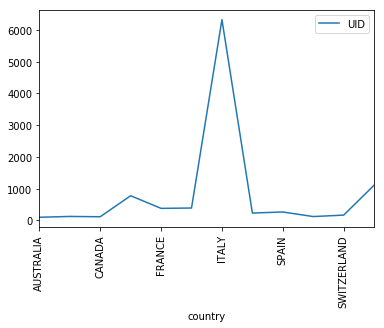

In [84]:

g2=pd.DataFrame(grouped['UID'].count())

g2=g2[g2.UID > 99]

g2.plot(rot=90)
plt.show()


# Merge, join, append DFs

In order to combine DFs several logics are available

To apply easily on our dataset we build 2 subsets with a smaller numer of columns

pubs_df_reduced
affs_df_reduced




In [87]:
affs_df_reduced = affs_df.sort_values(by=['UID']).loc[0:10 ,['UID', 'organization', 'country'] ]
pubs_df_reduced = pubs_df.sort_values(by=['UID']).loc[0:5 ,['UID', 'itemtitle', 'source', 'pubyear'] ]

pubs_df_reduced

,UID,itemtitle,source,pubyear
0,WOS:000071806400001,An organizational assessment of interfirm coor...,ORGANIZATION STUDIES,1997
1,WOS:000072608300005,Pension reform and economic performance under ...,ECONOMIC JOURNAL,1998
2,WOS:000073333300005,Exploiting and creating knowledge through cust...,R & D MANAGEMENT,1998
3,WOS:000073475100004,The optimality of nominal contracts,ECONOMIC THEORY,1998
4,WOS:000073918900007,"Well calibrated, coherent forecasting systems",THEORY OF PROBABILITY AND ITS APPLICATIONS,1998
5,WOS:000073954500017,Some conceptual and research barriers to the u...,CALIFORNIA MANAGEMENT REVIEW,1998


### Concat()
Concatenating pandas objects together with concat():
performs concatenation operations along an axis while performing optional set logic (union or intersection) of the indexes (if any) on the other axes.

pd.concat(objs, axis=0, join='outer', join_axes=None, ignore_index=False,
          keys=None, levels=None, names=None, verify_integrity=False,
          copy=True)
          
join : {‘inner’, ‘outer’}, default ‘outer’

axis : {0/’index’, 1/’columns’}, default 0
The axis to concatenate along
( 0 --> appends vertically , 1 orizzontally)

join_axes : list of Index objects
Specific indexes to use for the other n - 1 axes instead of performing inner/outer set logic
          
sort : boolean, default None
Sort non-concatenation axis if it is not already aligned when join is ‘outer’.                   
   
ignore_index : boolean, default False
If True, do not use the index values along the concatenation axis   
   
          
let's just concat() two DFs:

the result brings all columns, with NaN value where the column is missing in one DF        

(note index column has overlapping values: to avoid add ignore_index=True)


In [91]:
frames = [affs_df_reduced, pubs_df_reduced]

pd.concat(frames, sort = True)  


,UID,country,itemtitle,organization,pubyear,source
0,WOS:000071806400001,ITALY,NaN,UNIVERSITA DI MODENA E REGGIO EMILIA,NaN,NaN
1,WOS:000071806400001,ITALY,NaN,UNIV L BOCCONI,NaN,NaN
2,WOS:000072608300005,ENGLAND,NaN,UNIVERSITY OF OXFORD,NaN,NaN
3,WOS:000072608300005,ITALY,NaN,UNIV BOCCONI,NaN,NaN
4,WOS:000073333300005,ITALY,NaN,UNIVERSITY OF URBINO,NaN,NaN
5,WOS:000073333300005,ITALY,NaN,UNIVERSITY OF URBINO,NaN,NaN
6,WOS:000073333300005,ITALY,NaN,UNIV L BOCCONI,NaN,NaN
8,WOS:000073475100004,ITALY,NaN,UNIV BOCCONI,NaN,NaN
9,WOS:000073475100004,ITALY,NaN,INNOCENZO GASPARINI INST ECON RES,NaN,NaN
7,WOS:000073475100004,USA,NaN,UNIVERSITY OF TEXAS AUSTIN,NaN,NaN


### Append()

append is a shortcut to concat() if you need to concatenate along axis=0, namely the index 


DataFrame.append(other, ignore_index=False, verify_integrity=False, sort=None)

We try the same as above, adding the ignore_index=True clause



In [89]:
affs_df_reduced.append(pubs_df_reduced, ignore_index = True, sort=True)


,UID,country,itemtitle,organization,pubyear,source
0,WOS:000071806400001,ITALY,NaN,UNIVERSITA DI MODENA E REGGIO EMILIA,NaN,NaN
1,WOS:000071806400001,ITALY,NaN,UNIV L BOCCONI,NaN,NaN
2,WOS:000072608300005,ENGLAND,NaN,UNIVERSITY OF OXFORD,NaN,NaN
3,WOS:000072608300005,ITALY,NaN,UNIV BOCCONI,NaN,NaN
4,WOS:000073333300005,ITALY,NaN,UNIVERSITY OF URBINO,NaN,NaN
5,WOS:000073333300005,ITALY,NaN,UNIVERSITY OF URBINO,NaN,NaN
6,WOS:000073333300005,ITALY,NaN,UNIV L BOCCONI,NaN,NaN
7,WOS:000073475100004,ITALY,NaN,UNIV BOCCONI,NaN,NaN
8,WOS:000073475100004,ITALY,NaN,INNOCENZO GASPARINI INST ECON RES,NaN,NaN
9,WOS:000073475100004,USA,NaN,UNIVERSITY OF TEXAS AUSTIN,NaN,NaN


## Merge()

pandas.merge(left, right, how='inner', on=None, left_on=None, right_on=None, left_index=False, right_index=False, sort=False, suffixes=('_x', '_y'), copy=True, indicator=False, validate=None)

how : {‘left’, ‘right’, ‘outer’, ‘inner’}, default ‘inner’


#### Merge method    	SQL Join Name      	Description
            left    LEFT OUTER JOIN	    Uses keys from left frame only
            right	RIGHT OUTER JOIN	Uses keys from right frame only
            outer	FULL OUTER JOIN	    Uses union of keys from both frames
            inner	INNER JOIN          Uses intersection of keys from both frames


on : label or list (columns in common - These must be found in both DataFrames)

indicator : bool or str, default False: If True, adds a column to output DataFrame called “_merge” with information on the source of each row

We show now a DF merge between affs and pubs by UID


In [96]:
pd.merge(affs_df_reduced, pubs_df_reduced, how= 'outer' , on = ['UID'])


,UID,organization,country,itemtitle,source,pubyear
0,WOS:000071806400001,UNIVERSITA DI MODENA E REGGIO EMILIA,ITALY,An organizational assessment of interfirm coor...,ORGANIZATION STUDIES,1997
1,WOS:000071806400001,UNIV L BOCCONI,ITALY,An organizational assessment of interfirm coor...,ORGANIZATION STUDIES,1997
2,WOS:000072608300005,UNIVERSITY OF OXFORD,ENGLAND,Pension reform and economic performance under ...,ECONOMIC JOURNAL,1998
3,WOS:000072608300005,UNIV BOCCONI,ITALY,Pension reform and economic performance under ...,ECONOMIC JOURNAL,1998
4,WOS:000073333300005,UNIVERSITY OF URBINO,ITALY,Exploiting and creating knowledge through cust...,R & D MANAGEMENT,1998
5,WOS:000073333300005,UNIVERSITY OF URBINO,ITALY,Exploiting and creating knowledge through cust...,R & D MANAGEMENT,1998
6,WOS:000073333300005,UNIV L BOCCONI,ITALY,Exploiting and creating knowledge through cust...,R & D MANAGEMENT,1998
7,WOS:000073475100004,UNIV BOCCONI,ITALY,The optimality of nominal contracts,ECONOMIC THEORY,1998
8,WOS:000073475100004,INNOCENZO GASPARINI INST ECON RES,ITALY,The optimality of nominal contracts,ECONOMIC THEORY,1998
9,WOS:000073475100004,UNIVERSITY OF TEXAS AUSTIN,USA,The optimality of nominal contracts,ECONOMIC THEORY,1998


Note: for last record we have no affiliations since aff reduced dataframe did not include it; try rerunning adding indicator = 'indicator_column' to crosscheck;

Try also using how= 'inner'

It could be also possible to set NaN to a default value with method
.fillna('value') (if more columns use a dictionary)


In [98]:
df6 =pd.merge(affs_df_reduced, pubs_df_reduced, how= 'outer' , on = ['UID'], indicator='indicator_column').fillna({'organization': 'no org', 'country': 'no cy'})
df6

,UID,organization,country,itemtitle,source,pubyear,indicator_column
0,WOS:000071806400001,UNIVERSITA DI MODENA E REGGIO EMILIA,ITALY,An organizational assessment of interfirm coor...,ORGANIZATION STUDIES,1997,both
1,WOS:000071806400001,UNIV L BOCCONI,ITALY,An organizational assessment of interfirm coor...,ORGANIZATION STUDIES,1997,both
2,WOS:000072608300005,UNIVERSITY OF OXFORD,ENGLAND,Pension reform and economic performance under ...,ECONOMIC JOURNAL,1998,both
3,WOS:000072608300005,UNIV BOCCONI,ITALY,Pension reform and economic performance under ...,ECONOMIC JOURNAL,1998,both
4,WOS:000073333300005,UNIVERSITY OF URBINO,ITALY,Exploiting and creating knowledge through cust...,R & D MANAGEMENT,1998,both
5,WOS:000073333300005,UNIVERSITY OF URBINO,ITALY,Exploiting and creating knowledge through cust...,R & D MANAGEMENT,1998,both
6,WOS:000073333300005,UNIV L BOCCONI,ITALY,Exploiting and creating knowledge through cust...,R & D MANAGEMENT,1998,both
7,WOS:000073475100004,UNIV BOCCONI,ITALY,The optimality of nominal contracts,ECONOMIC THEORY,1998,both
8,WOS:000073475100004,INNOCENZO GASPARINI INST ECON RES,ITALY,The optimality of nominal contracts,ECONOMIC THEORY,1998,both
9,WOS:000073475100004,UNIVERSITY OF TEXAS AUSTIN,USA,The optimality of nominal contracts,ECONOMIC THEORY,1998,both


## Join

Method .join() is more convenient when mergin on index.
result = left.join(right, how='outer')

in cases where we want to merge on another column we can use .set_index() method.


In [103]:
pubs_df_reduced.set_index('UID').join(affs_df_reduced.set_index('UID'), how='left')

,itemtitle,source,pubyear,organization,country
UID,,,,,
WOS:000071806400001,An organizational assessment of interfirm coor...,ORGANIZATION STUDIES,1997,UNIVERSITA DI MODENA E REGGIO EMILIA,ITALY
WOS:000071806400001,An organizational assessment of interfirm coor...,ORGANIZATION STUDIES,1997,UNIV L BOCCONI,ITALY
WOS:000072608300005,Pension reform and economic performance under ...,ECONOMIC JOURNAL,1998,UNIVERSITY OF OXFORD,ENGLAND
WOS:000072608300005,Pension reform and economic performance under ...,ECONOMIC JOURNAL,1998,UNIV BOCCONI,ITALY
WOS:000073333300005,Exploiting and creating knowledge through cust...,R & D MANAGEMENT,1998,UNIVERSITY OF URBINO,ITALY
WOS:000073333300005,Exploiting and creating knowledge through cust...,R & D MANAGEMENT,1998,UNIVERSITY OF URBINO,ITALY
WOS:000073333300005,Exploiting and creating knowledge through cust...,R & D MANAGEMENT,1998,UNIV L BOCCONI,ITALY
WOS:000073475100004,The optimality of nominal contracts,ECONOMIC THEORY,1998,UNIV BOCCONI,ITALY
WOS:000073475100004,The optimality of nominal contracts,ECONOMIC THEORY,1998,INNOCENZO GASPARINI INST ECON RES,ITALY


## Reshaping DFs

### Stack
The stack() method “compresses” a level in the DataFrame’s columns.

the inverse operation of stack() is unstack(), which by default unstacks the last level
(needs multilevel indexed DFs)

In the following example first 10 affiliations are taken (df1) and a count by uid/country is 
built (df2)
eventually df2 has 2 keys since groupby has 2 levels; unstack creates a set of columns with country names


In [117]:
df1 = affs_df[:10]
df2 = df1.groupby(['UID', 'country'])['organization'].count()
df2.unstack(level=-1)



country,ENGLAND,ITALY,USA
UID,,,
WOS:000071806400001,NaN,2.0,NaN
WOS:000072608300005,1.0,1.0,NaN
WOS:000073333300005,NaN,3.0,NaN
WOS:000073475100004,NaN,2.0,1.0


In [115]:
# we take 2 columns only and we reindex so we stack on the new index

df2=df1[['organization','UID']][:10].set_index('organization')
df2.stack()

organization                             
UNIVERSITA DI MODENA E REGGIO EMILIA  UID    WOS:000071806400001
UNIV L BOCCONI                        UID    WOS:000071806400001
UNIVERSITY OF OXFORD                  UID    WOS:000072608300005
UNIV BOCCONI                          UID    WOS:000072608300005
UNIVERSITY OF URBINO                  UID    WOS:000073333300005
                                      UID    WOS:000073333300005
UNIV L BOCCONI                        UID    WOS:000073333300005
UNIVERSITY OF TEXAS AUSTIN            UID    WOS:000073475100004
UNIV BOCCONI                          UID    WOS:000073475100004
INNOCENZO GASPARINI INST ECON RES     UID    WOS:000073475100004
dtype: object

### Pivot tables

pandas.pivot_table(data, values=None, index=None, columns=None, aggfunc='mean', fill_value=None, margins=False, dropna=True, margins_name='All')


data : DataFrame
values : column to aggregate, optional
index : column, Grouper, array, or list of the previous
If an array is passed, it must be the same length as the data. The list can contain any of the other types (except list). Keys to group by on the pivot table index. If an array is passed, it is being used as the same manner as column values.

columns : column, Grouper, array, or list of the previous
If an array is passed, it must be the same length as the data. The list can contain any of the other types (except list). Keys to group by on the pivot table column. If an array is passed, it is being used as the same manner as column values.

aggfunc : function, list of functions, dict, default numpy.mean
If list of functions passed, the resulting pivot table will have hierarchical columns whose top level are the function names (inferred from the function objects themselves) If dict is passed, the key is column to aggregate and value is function or list of functions

fill_value : scalar, default None
Value to replace missing values with

margins : boolean, default False
Add all row / columns (e.g. for subtotal / grand totals)

dropna : boolean, default True
Do not include columns whose entries are all NaN

margins_name : string, default ‘All’
Name of the row / column that will contain the totals when margins is True.



In [3]:

df1 = pubs_df.loc[:15,['source', 'pubyear', 'UID']]
#df2 = df1.groupby(['source', 'pubyear']).count()
#pd.pivot_table(df2, index = ['source'], columns = ['pubyear'],  fill_value=0, dropna = False )

pd.pivot_table(df1, index = ['source'], columns = ['pubyear'],  fill_value=0, dropna = False, aggfunc='count' )


UID     
pubyear                                    1997 1998
source                                              
BUSINESS HISTORY                              0    1
CALIFORNIA MANAGEMENT REVIEW                  0    1
ECONOMIC JOURNAL                              0    1
ECONOMIC THEORY                               0    1
ECONOMICS OF TRANSITION                       0    2
EUROPEAN ECONOMIC REVIEW                      0    3
JOURNAL OF BANKING & FINANCE                  0    1
JOURNAL OF INTERNATIONAL ECONOMICS            0    1
ORGANIZATION STUDIES                          1    1
R & D MANAGEMENT                              0    1
RESEARCH POLICY                               0    1
THEORY OF PROBABILITY AND ITS APPLICATIONS    0    1

Last step:

We create a pivot table with the range of collaboration years by insitution and type of publication.

First we create a joined DF, then we slice it and eventually make a pivot

In [5]:
import numpy as np


dfjoined= pd.merge(affs_df, pubs_df, how= 'inner' , on = ['UID'])
dfredux = dfjoined[['organization','pubyear', 'pubtype']].copy()

pd.pivot_table(dfredux, index = ['organization'], columns = ['pubtype'],
               values = ['pubyear'],fill_value=0, dropna = False,
               aggfunc={'min','max'})[0:15]



pubyear          \
                                                       max           
pubtype                                     Book in series Journal   
organization                                                         
A FIORINI HOSP                                           0    2015   
AALTO UNIVERSITY                                         0    2014   
AARHUS UNIVERSITY                                        0    2016   
ABBIATEGRASSO HOSP                                       0    2007   
ABBVIE                                                   0    2014   
ABO AKADEMI UNIVERSITY                                   0    2002   
ABT ASSOCIATES INC                                       0    2013   
ACAD SCI RES                                             0    2014   
ACAD SPECIAL EDUC                                        0    2016   
ACXEL INT                                                0    1999   
AFRICAN DEVELOPMENT BANK GROUP (AFDB)                    0    2010   
AFRICAN ECONOMIC RESEARCH CONSORTIUM (AERC)              0    2014   
AGCY HLTH CARE & SOCIAL SERV EMILIA ROMAGNA              0    2015   
AGROPARISTECH                                            0    2017   
AIR FRANCE KLM                                           0    2012   

                                                                    
                                                       min          
pubtype                                     Book in series Journal  
organization                                                        
A FIORINI HOSP                                           0    2015  
AALTO UNIVERSITY                                         0    2014  
AARHUS UNIVERSITY                                        0    2005  
ABBIATEGRASSO HOSP                                       0    2007  
ABBVIE                                                   0    2014  
ABO AKADEMI UNIVERSITY                                   0    2002  
ABT ASSOCIATES INC                                       0    2013  
ACAD SCI RES                                             0    2014  
ACAD SPECIAL EDUC                                        0    2016  
ACXEL INT                                                0    1999  
AFRICAN DEVELOPMENT BANK GROUP (AFDB)                    0    2010  
AFRICAN ECONOMIC RESEARCH CONSORTIUM (AERC)              0    2014  
AGCY HLTH CARE & SOCIAL SERV EMILIA ROMAGNA              0    2015  
AGROPARISTECH                                            0    2017  
AIR FRANCE KLM                                           0    2011

## Categorical data 

pandas can include categorical data in a DataFrame.
A categorical variable takes on a limited, and usually fixed, number of possible values



In [6]:

df1 = pubs_df.loc[:15].copy()  #make a copy since we are going to modify
series1 = pd.DataFrame({'raw_rank': ['A', 'B', 'B', 'C', 'A', 'B', 'B', 'C', 'A', 'B', 'B', 'C',
                                     'A', 'B', 'B', 'C']})
df1['grade'] = series1['raw_rank'].astype('category')
df1['grade']



0     A
1     B
2     B
3     C
4     A
5     B
6     B
7     C
8     A
9     B
10    B
11    C
12    A
13    B
14    B
15    C
Name: grade, dtype: category
Categories (3, object): [A, B, C]

Here we rename categories (.cat.categories ) 
and we set the full range by adding missing categories (.cat.set_categories)

In [7]:
df1["grade"].cat.categories = ["very good", "good", "bad"]
df1["grade"] = df1["grade"].cat.set_categories(["very bad", "bad", "medium",
                                                 "good", "very good"])
df1["grade"]


0     very good
1          good
2          good
3           bad
4     very good
5          good
6          good
7           bad
8     very good
9          good
10         good
11          bad
12    very good
13         good
14         good
15          bad
Name: grade, dtype: category
Categories (5, object): [very bad, bad, medium, good, very good]

## Data output: csv and HDF5

Previously we imported data with read_csv() function

Inverse function is to_csv(filename)

Another option is HDFStore (Hierarchical Data Format), a dict-like object which reads and writes pandas using the high performance HDF5  format using the PyTables library (important : upgrade to PyTables >= 3.2 to avoid a bug; check with pip freeze).

DataFrame.to_hdf(path_or_buf, key, **kwargs)

pandas.read_hdf(path_or_buf, key=None, mode='r', **kwargs)


path_or_buf : str or pandas.HDFStore
File path or HDFStore object; default extension h5

key : str
Identifier for the group in the store.

mode : {‘a’, ‘w’, ‘r+’}, default ‘a’




In [ ]:
df2.to_hdf('c:\\temp\\df_test.h5', 'df2')
print('Dataframe succesfully exported!')

## Using lambda function on dataframes:

lambda functions are syntetic writing of functions that, thanks to apply method
can run across all dataframe.
A lambda function can take any number of arguments, but can only have one expression

x = lambda a, b, c : a + b + c
print(x(5, 6, 2))

df.text = df.text.apply(lambda x: x.lower())

in the example below we set lower case to organization field, then
set a new column BOC containing B if affiliation contains the word 'bocconi'
'O' else

In [ ]:
affs_df['organization']= affs_df['organization'].apply(lambda x: x.lower())
affs_df['BOC']= affs_df['organization'].apply(lambda x: 'O' if 'BOCCONI' not in x else 'B')
affs_df.head()